In [1]:
# -------------------------------------------------------------------------------------- #
# ---------- DISCRETE DIPOLE METHOD FOR UV-VIS CALCULATIONS FROM DIPOLE DATA ----------- #
# -------------------------------------------------------------------------------------- #
import os
import json
import pathlib
import numpy as np
import pandas as pd
from dda_complex128 import DDA
import tensorflow as tf
import fresnel
from matplotlib import pyplot as plt
def delete_1D(new_position,position):
    A=np.array(np.around(new_position,7)).tolist()
    B=np.array(np.around(position,7)).tolist()
    A = [i for i in A if i not in B]
    return A
import pickle

2022-03-08 19:54:39.552264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# GPU Device Config
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder_path = pathlib.Path().absolute()

# Read in initial data

In [3]:
random_seed = 42
events = np.load(f'./event_{random_seed}.npy',allow_pickle=True).tolist()
with open(f'coord_infor_{random_seed}.pickle', 'rb') as handle:
    coord_infor = pickle.load(handle)

# read in the generated dipole position
dipole_positions = np.loadtxt(f'./dipole_positions_{random_seed}.csv',delimiter=',')
# read in the calculated atom number inside the dipoles
dipole_current_coord = np.loadtxt(f'./dipole_current_coord_{random_seed}.csv',delimiter=',')

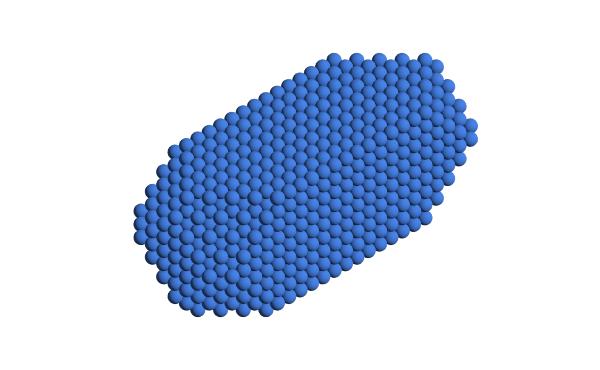

In [4]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions[np.array(dipole_current_coord)==32]), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions[np.array(dipole_current_coord)==32]
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [5]:
np.savetxt(f'./initial_dipole_{random_seed}.csv',dipole_positions[np.array(dipole_current_coord)==32]/1.5,delimiter=',')

# Simulations for the initial structure

In [ ]:
config = {'gpu_device': '/GPU:0',
          'dipole_length': 0.41*1.5,
          'min_wavelength': 0.4,
          'max_wavelength': 0.8,
          'num_wavelengths': 41,
          'ref_medium': 1.333,
          'rotation_steps': 10,
          'folder_path': None,
          'calculate_electricField': False,
          'lattice_constant': 0.41,
          'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
          'metals': ["Au","Ag"],
          'dipole_data': str(current_folder_path)+ f'/initial_dipole_{random_seed}.csv',
          "ratio":[1.0, 0.0],
          "method":"homo",
          "custom_ratio_path":None,
          'atom_data':None,
          'lattice_constant': None
        }
config['folder_path'] = './1/'
np_dda = DDA(config)
np_dda.run_DDA()
np_dda.plot_spectra()
# Save the cross section data
np.savetxt(config['folder_path'] +"/data.csv",np.array(np_dda.C_cross_total),delimiter=",")

Reading refractive index and dipole data


In [ ]:
plt.plot(np.array(np_dda.C_cross_total))

# Check the final structure from the KMC

In [ ]:
random_seed = 42
events = np.load(f'./event_{random_seed}.npy',allow_pickle=True).tolist()
with open(f'coord_infor_{random_seed}.pickle', 'rb') as handle:
    coord_infor = pickle.load(handle)
# read in the overall dipole position
dipole_positions = np.loadtxt(f'./dipole_positions_{random_seed}.csv',delimiter=',')
# read in the overall dipole position
np.savetxt(f'./dipole_positions_translated_{random_seed}.csv',dipole_positions/1.5,delimiter=',')

In [ ]:
config = {'gpu_device': '/GPU:0',
          'dipole_length': 0.41*1.5,
          'min_wavelength': 0.4,
          'max_wavelength': 0.8,
          'num_wavelengths': 41,
          'ref_medium': 1.333,
          'rotation_steps': 10,
          'folder_path': None,
          'calculate_electricField': False,
          'lattice_constant': 0.41,
          'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
          'metals': ["Au","Ag"],
          'dipole_data': str(current_folder_path)+ f'/dipole_positions_translated_{random_seed}.csv',
          "ratio":[1.0, 0.0],
          "method":"homo",
          'atom_data':None,
          'lattice_constant': 0.41
        }
config['folder_path'] = './1'
np_dda = DDA(config)
# get the pure refractive index
ref_target_pure = np_dda.calculate_homo_polarizability()

In [ ]:
# calculate the alpha_j for the final growth model
ratios = np.array([site['coord'] for site in list(coord_infor.values())]).T
ratios = ratios/ratios.sum(axis=0)
ref_targets = []
for i in range(len(np_dda.dipole_list)):
    ref_targets.append((ratios[:,i].reshape(-1,1)*ref_target_pure).sum(axis=0))
ref_targets = np.array(ref_targets)
alpha_j_total = []

for ref_target in ref_targets:  
    ref_rel = ref_target/np_dda.ref_medium 
    wl_rel = np_dda.wl_exp/np_dda.ref_medium 
    np_dda.k = 2*np.pi/wl_rel 

    # Clausius-Mossotti polarizability and FLTRD polarizability 
    alpha_CM=3*(np_dda.dl**3)*(ref_rel**2-1)/4/np.pi/(ref_rel**2+2)
    D = alpha_CM/(np_dda.dl**3)*(4/3*((np_dda.k*np_dda.dl)**2)+
        2/3/np.pi*np.log((np.pi-np_dda.k*np_dda.dl)/(np.pi+np_dda.k*np_dda.dl))*((np_dda.k*np_dda.dl)**3)+2j/3*((np_dda.k*np_dda.dl)**3))
    alpha_j = alpha_CM/(1+D)
    alpha_j_total.append(alpha_j)        
np_dda.alpha_j = np.array(alpha_j_total).astype("complex128")

In [ ]:
rate = 10**6
coord_sites = [site['coord'] for site in list(coord_infor.values())]
for i in range(np_dda.alpha_j.shape[0]):
    if sum(coord_sites[i]) != 32:
        np_dda.alpha_j[i,:] = np_dda.alpha_j[i,:]/rate

In [ ]:
np_dda.run_DDA()
np_dda.plot_spectra()
# Save the cross section data
np.savetxt(config['folder_path'] +"/data.csv",np.array(np_dda.C_cross_total),delimiter=",")

In [ ]:
plt.plot(np.array(np_dda.C_cross_total))

# Go through the trajectory and record the atom ratio change

In [ ]:
random_seed = 42
events = np.load(f'./event_{random_seed}.npy',allow_pickle=True).tolist()
with open(f'coord_infor_{random_seed}.pickle', 'rb') as handle:
    coord_infor = pickle.load(handle)
# read in the overall dipole position
dipole_positions = np.loadtxt(f'./dipole_positions_{random_seed}.csv',delimiter=',')
# read in the overall dipole position
np.savetxt(f'./dipole_positions_translated_{random_seed}.csv',dipole_positions/1.5,delimiter=',')

In [ ]:
config = {'gpu_device': '/GPU:0',
          'dipole_length': 0.41*1.5,
          'min_wavelength': 0.4,
          'max_wavelength': 0.8,
          'num_wavelengths': 41,
          'ref_medium': 1.333,
          'rotation_steps': 10,
          'folder_path': None,
          'calculate_electricField': False,
          'lattice_constant': 0.41,
          'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
          'metals': ["Au","Ag"],
          'dipole_data': str(current_folder_path)+ f'/dipole_positions_translated_{random_seed}.csv',
          "ratio":[1.0, 0.0],
          "method":"homo",
          'atom_data':None,
          'lattice_constant': 0.41
        }
config['folder_path'] = './1'
np_dda = DDA(config)
# get the pure refractive index
ref_target_pure = np_dda.calculate_homo_polarizability()

In [ ]:
# reverse the trajecotry
# reverse the event that will happen
events = events[::-1]
# get the indexes of the dipoles that we will change according to the event in the reverse order
dipole_change_indexes = [np.where((dipole_positions == np.array(event[0])).all(axis=1))[0][0] for event in events]
atom_ratios_total = []
atom_ratios = (np.array([site['coord'] for site in list(coord_infor.values())]).T)
atom_ratios_total.append(atom_ratios.copy())

In [ ]:
for count in range(len(events)):
    atom_ratio_temp = atom_ratios.copy()
    if events[count][2] == 'replace':
        if events[count][3] == 'Au':
            atom_ratio_temp[0,dipole_change_indexes[count]] = atom_ratio_temp[0,dipole_change_indexes[count]] + 1
            atom_ratio_temp[1,dipole_change_indexes[count]] = atom_ratio_temp[1,dipole_change_indexes[count]] - 1
        else:
            atom_ratio_temp[0,dipole_change_indexes[count]] = atom_ratio_temp[0,dipole_change_indexes[count]] - 1
            atom_ratio_temp[1,dipole_change_indexes[count]] = atom_ratio_temp[1,dipole_change_indexes[count]] + 1
            
    elif events[count][2] == 'add':
        atom_ratio_temp[:,dipole_change_indexes[count]] = np.array(events[count][1]).T
        if events[count][3] == 'Au':
            atom_ratio_temp[0,dipole_change_indexes[count]] = atom_ratio_temp[0,dipole_change_indexes[count]] - 1
        else:
            atom_ratio_temp[1,dipole_change_indexes[count]] = atom_ratio_temp[1,dipole_change_indexes[count]] - 1
    else:
        atom_ratio_temp[:,dipole_change_indexes[count]] = np.array(events[count][1]).T
        if events[count][3] == 'Au':
            atom_ratio_temp[0,dipole_change_indexes[count]] = atom_ratio_temp[0,dipole_change_indexes[count]] + 1
        else:
            atom_ratio_temp[1,dipole_change_indexes[count]] = atom_ratio_temp[1,dipole_change_indexes[count]] + 1
    atom_ratios = atom_ratio_temp
    atom_ratios_total.append(atom_ratios.copy())

In [ ]:
# the Ag composition should be zero in the initial structure
print(((atom_ratios_total[-1][1])[(atom_ratios_total[-1].sum(axis=0) == 32)] == 0).all())
# the dipoles should be consistent from the direct read and after reverse the trajecoty
print(
    ((atom_ratios_total[-1].sum(axis=0) == 32) == (dipole_current_coord == 32)).all()
)

In [ ]:
np_dda_alpha_j_total = []
for atom_ratio_temp in atom_ratios_total:
    # calculate the alpha_j for the final growth model
    ratios = atom_ratio_temp/atom_ratio_temp.sum(axis=0)
    ref_targets = []
    for i in range(len(np_dda.dipole_list)):
        ref_targets.append((ratios[:,i].reshape(-1,1)*ref_target_pure).sum(axis=0))
    ref_targets = np.array(ref_targets)
    alpha_j_total = []

    for ref_target in ref_targets:  
        ref_rel = ref_target/np_dda.ref_medium 
        wl_rel = np_dda.wl_exp/np_dda.ref_medium 
        np_dda.k = 2*np.pi/wl_rel 

        # Clausius-Mossotti polarizability and FLTRD polarizability 
        alpha_CM=3*(np_dda.dl**3)*(ref_rel**2-1)/4/np.pi/(ref_rel**2+2)
        D = alpha_CM/(np_dda.dl**3)*(4/3*((np_dda.k*np_dda.dl)**2)+
            2/3/np.pi*np.log((np.pi-np_dda.k*np_dda.dl)/(np.pi+np_dda.k*np_dda.dl))*((np_dda.k*np_dda.dl)**3)+2j/3*((np_dda.k*np_dda.dl)**3))
        alpha_j = alpha_CM/(1+D)
        alpha_j_total.append(alpha_j)        
        
    alpha_j_total = np.array(alpha_j_total).astype("complex128")
    
    rate = 10**6
    for i in range(alpha_j_total.shape[0]):
        if sum(atom_ratio_temp[:,i]) != 32:
            alpha_j_total[i,:] = np_dda.alpha_j[i,:]/rate
            
    np_dda_alpha_j_total.append(alpha_j_total.copy())
# initialize the original alpha j to start
np_dda.alpha_j = np_dda_alpha_j_total[0]

In [ ]:
# set the position of the matrix rank-one decomposition
atom_index = [[i for i in range(3*j,3*j+3)] for j in dipole_change_indexes]
atom_index = np.array(atom_index).flatten().tolist()
np_dda.flip_infor = []
np_dda.flip_infor.append(atom_index)
# intialize with the originial polarzibility of the initial structure
for np_dda_alpha_j_total_temp in np_dda_alpha_j_total:
    np_dda.flip_infor.append(
         np.repeat(np_dda_alpha_j_total_temp,3,axis=0)
       )

In [ ]:
t_total = np_dda.calculate_spectrum_trajectories_v2_2()
t_total = np.array(t_total)
np.savetxt(config['folder_path'] +f'/data_t_{rate}_128_test.csv',t_total,delimiter=',')
np.savetxt(config['folder_path'] +f'/C_cross_{rate}_128_test.csv',np.array(np_dda.C_cross_total),delimiter=',')

In [ ]:
data_path = './1'
rate = 10**6
data2 = np.loadtxt(data_path +f'/C_cross_{rate}_128_test.csv',delimiter=',')
print(int(data2.shape[1]))
for i in range(int(data2.shape[1])):
    plt.plot(np.linspace(0.4,0.8,41),data2[:,i])
plt.plot(np.linspace(0.4,0.8,41),data2[:,-1])
plt.show()

In [ ]:
plt.plot(np.linspace(0.4,0.8,41),data2[:,0])

In [ ]:
data_path = './2'
rate = 10**6
data2 = np.loadtxt(data_path +f'/C_cross_{rate}_128_test.csv',delimiter=',')
print(int(data2.shape[1]))
for i in range(int(data2.shape[1])):
    plt.plot(np.linspace(0.4,0.8,41),data2[:,i])
plt.plot(np.linspace(0.4,0.8,41),data2[:,-1])
plt.show()